In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from collections import Counter
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
sns.set()

In [3]:
def accuracy(y_pred, y_test):
    return np.sum(y_pred == y_test) / len(y_test)

### K-Nearest Neighbors (KNN)

In [21]:
cmap = ListedColormap(["#FF0000", "#00FF00", "#0000FF"])
iris = datasets.load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# plt.figure()
# plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=20)
# plt.show()

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum(x1 - x2) ** 2)


class KNN:
    
    def __init__(self, k=3):
        self.k = k
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X):
        predicted_labels = [self._predict(x) for x in X]
        return np.array(predicted_labels)
        
    def _predict(self, x):
        # Compute distances
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        
        # get k nearest samples, labels
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        # majority vote, most common class label
        most_common = Counter(k_nearest_labels).most_common(1)
        
        return most_common[0][0]

clf = KNN(k=5)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

acc = accuracy(predictions, y_test) 
print(f"Accuracy = {np.round(acc*100, 2)} %")

Accuracy = 96.67 %


### Linear Regression

#### Approximation

$$ \hat y = wx + b$$

#### Cost function

$$ MSE = J(w, b) = \frac{1}{n} \sum_{i=1}^n (y_i - (wx_i + b))^2 $$

$$ \nabla J'(m, b) = \begin{pmatrix} \frac{df}{dw} \\ \frac{df}{db} \end{pmatrix} $$

#### Gradient Descent

* Move w in the direction of the steepest gradient
* Update rules:
  * $ w = w - \alpha * dw $
  * $ b = b - \alpha * db $
  * $\alpha$ is the learning rate

MSE = 305.7719958301902


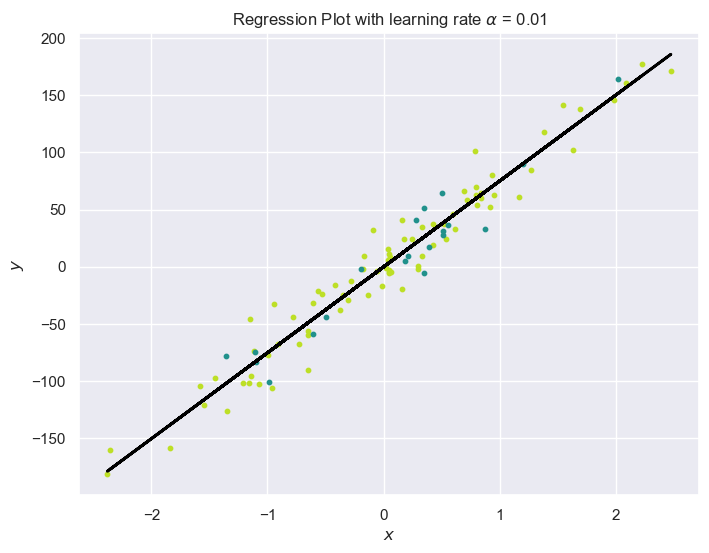

In [84]:
X, y = datasets.make_regression(n_samples=100, n_features=1, noise=20, random_state=4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# fig = plt.figure(figsize=(8, 6))
# plt.scatter(X[:, 0], y, color='b', marker="o", s=30)
# plt.show()

class LinearRegression:
    
    def __init__(self, lr=0.001, n_iterations=1000):
        self.lr = lr
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        
    def fit(self, X, y):
        # init parameters
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # gradient descent
        for _ in range(self.n_iterations):
            y_predicted = np.dot(X, self.weights) + self.bias
            
            dw = (1/n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1/n_samples) * np.sum(y_predicted - y)
            
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
    
    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# lrs = np.linspace(0.0001, 1, 10)
# mses = list()

# for lr in lrs[::-1]:

learning_rate = 0.01

regressor = LinearRegression(lr=learning_rate)
regressor.fit(X_train, y_train)
predicted = regressor.predict(X_test)
mse_value = mse(y_test, predicted)
    
print(f"MSE = {mse_value}")

# mses.append(mse_value)

cmap = plt.get_cmap("viridis")

# plt.plot(lrs, mses)
# plt.semilogx()
# plt.title("MSE evolution with different learning rates")
# plt.xlabel("Learning Rate $\\alpha$")
# plt.ylabel("$MSE$")
# plt.show()

y_pred_line = regressor.predict(X)

fig = plt.figure(figsize=(8, 6))
m1 = plt.scatter(X_train, y_train, color=cmap(0.9), s=10)
m2 = plt.scatter(X_test, y_test, color=cmap(0.5), s=10)
plt.plot(X, y_pred_line, color="black", linewidth=2, label="Prediction")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title(f"Regression Plot with learning rate $\\alpha$ = {learning_rate}")
plt.show()

### Logistic Regression

$$
\hat y = h_\theta(x) = \frac{1}{1+e^{-wx+b}}
$$

* Analogy: Sigmoid Function $ s(x) = \frac{1}{1+e^{-x}} $
* Instead of MSE, Cross Entropy $J(w, b) = J(\theta) = \frac{1}{n} \sum_{i=1}^n [y^i log(h_\theta(x^i)) + (1 - y^i) log(1 - h_\theta(x^i))] $
* Gradient Descent = $J'(\theta)$

In [22]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class LogisticRegression:
    
    def __init__(self, lr=0.001, n_iterations=1000):
        self.lr =lr
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for _ in range(self.n_iterations):
            linear_predictions = np.dot(X, self.weights) + self.bias
            predictions = sigmoid(linear_predictions)
            
            dw = (1/n_samples) * np.dot(X.T, (predictions - y))
            db = (1/n_samples) * np.sum(predictions - y)
            
            self.weights = self.weights - self.lr * dw
            self.bias = self.bias - self.lr * db
    
    def predict(self, X):
        linear_predictions = np.dot(X, self.weights) + self.bias
        y_predicted = sigmoid(linear_predictions)
        
        class_predictions = [0 if y <= 0.5 else 1 for y in y_predicted]
        
        return class_predictions
    
    
bc = datasets.load_breast_cancer()
X, y = bc.data, bc.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

clf = LogisticRegression(lr=0.01)
clf.fit(X_train, y_train)
y_predicted = clf.predict(X_test)

print(f"Accuracy = {accuracy(y_predicted, y_test)}")

Accuracy = 0.9210526315789473


C:\Users\janni\AppData\Local\Temp\ipykernel_3588\4270901784.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


### Decision Trees

* Given a multidimensional Dataset:
  * Calculate information gain (IG) with each possible split
  * Divide set with that featrue and value that gives th most IG
  * Divide tree and do the same for all created branches...
  * ...until a stopping criteria is reached

$$
IG = E(parent) - [weighted average] * E(children) \\
E = -\sum p(X) * log_2(p(X))
$$

* IG ... Information gain
* E ... Entropy
* p(X) ... number of times a node occured related to all notes
* Stopping criteria: max depth, min numbers of samples, min impurity decrease

In [45]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p>0])


    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


data = datasets.load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

clf = DecisionTree(max_depth=10)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

print(f"Accuracy = {accuracy(predictions, y_test)}")

Accuracy = 0.9210526315789473


### Random Forests

In [36]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_feature=None):
        self.n_trees = n_trees
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.n_features=n_feature
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split, n_features=self.n_features)
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_samples(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions
    

data = datasets.load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

clf = RandomForest(n_trees=20)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

print(f"Accuracy = {accuracy(predictions, y_test)}")

Accuracy = 0.9210526315789473


### Naive Bayes

$$
P(A|B) = \frac{P(B|A) * P(A)}{P(B)} \\
P(y|X) = \frac{P(X|y) * P(y)}{P(X)} = \frac{P(x_1|y)*P(x_2|y)*...*P(x_n|y) * P(y)}{P(X)}
$$

* $y = argmax_y P(y|X) = argmax_y P(y|X) * P(X) = argmax_y log(P(y|X))$
* $P(y)$ ... prior Probability
* $P(x_i|y)$ ... class conditional 

In [50]:
class NaiveBayes:
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)
        
        # calc mean, var, prior for each class
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)
        
        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[idx, :] = X_c.var(axis=0)
            self._priors[idx] = X_c.shape[0] / float(n_samples)
    
    def _pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        
        numerator = np.exp(-((x - mean) ** 2) / (2*var))
        nominator = np.sqrt(2 * np.pi * var)
        
        return numerator / nominator
        
    
    def _predict(self, x):
        posteriors = list()
        
        # calc posterior probability for each class
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            posterior = np.sum(np.log(self._pdf(idx, x)))
            posterior += prior
            posteriors.append(posterior)
            
        return self._classes[np.argmax(posteriors)]
    
    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)
    

X, y = datasets.make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=1234)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

nb = NaiveBayes()
nb.fit(X_train, y_train)
predictions = nb.predict(X_test)

print(f"Accuracy = {accuracy(predictions, y_test)}")

Accuracy = 0.93


### Principle Component Analysis

Shape of X = (150, 4)
Shape of tranformed X = (150, 2)


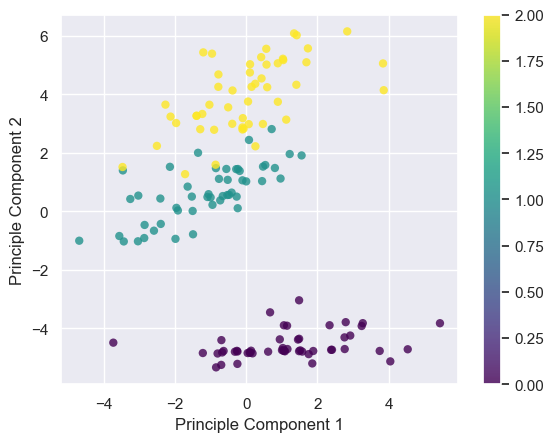

In [11]:
class PCA:
    
    def __init__(self, n_components) -> None:
        self.n_components = n_components
        self.components = None
        self.mean = None
        
    def fit(self, X):
        # mean centering
        self.mean = np.mean(X, axis=0)
        X = X - self.mean
        
        # covariance
        cov = np.cov(X.T)
        
        # eigenvectors, eigenvalues
        eigenvectors, eigenvalues = np.linalg.eig(cov)
        eigenvectors = eigenvectors.T
        
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]
        
        self.components = eigenvectors[:self.n_components]
        
    def transform(self, X):
        X = X - self.mean
        return np.dot(X, self.components.T)
    

data = datasets.load_iris()
X, y = data.data, data.target

pca = PCA(n_components=2)
pca.fit(X)
X_projected = pca.transform(X)

print(f"Shape of X = {X.shape}")
print(f"Shape of tranformed X = {X_projected.shape}")

x1 = X_projected[:, 0]
x2 = X_projected[:, 1]

plt.scatter(x1, x2, c=y, edgecolors="none", alpha=0.8, cmap=matplotlib.colormaps.get_cmap("viridis"))
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.colorbar()
plt.show()

### Perceptron

Simple linear Model
$$
f(x) = w^Tx + b
$$

with Activation Function (Unit step function, Heavyside Function)
$$
g(z) = \begin{align} \begin{cases} 1 & if\ z \ge 0 \\ 0 & otherwise \end{cases} \end{align}
$$

Leads to approximation

$$
\hat y = g(f(x)) = g(w^Tx+b)
$$

Accuracy = 1.0


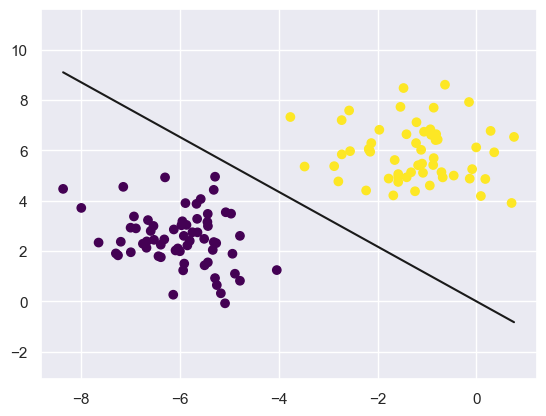

In [20]:
def unit_step_func(x):
    return np.where(x > 0, 1, 0)


class Perceptron:
    
    def __init__(self, learning_rate=0.01, n_iters=1000) -> None:
        self.lr = learning_rate
        self.n_iters = n_iters
        self.activation_func = unit_step_func
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # init parameters
        self.weights = np.random.uniform(0, 1, n_features)
        self.bias = 0
        
        y_ = np.where(y > 0, 1, 0)
        
        # learn weights
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                linear_output = np.dot(x_i, self.weights) + self.bias
                y_predicted = self.activation_func(linear_output)
                
                # update
                update = self.lr * (y_[idx] - y_predicted)
                self.weights += update * x_i
                self.bias += update
    
    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        y_predicted = self.activation_func(linear_output)
        return y_predicted
    
    
X, y = make_blobs(n_samples=150, n_features=2, centers=2, cluster_std=1.05, random_state=1234)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

p = Perceptron()
p.fit(X_train, y_train)
predictions = p.predict(X_test)

print(f"Accuracy = {accuracy(predictions, y_test)}")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c=y_train, cmap="viridis")

x0_1 = np.amin(X_train[:, 0])
x0_2 = np.amax(X_train[:, 0])

x1_1 = (-p.weights[0] * x0_1 - p.bias) / p.weights[1]
x1_2 = (-p.weights[0] * x0_2 - p.bias) / p.weights[1]

ax.plot([x0_1, x0_2], [x1_1, x1_2], 'k')

ymin = np.amin(X_train[:, 1])
ymax = np.amax(X_train[:, 1])

ax.set_ylim([ymin-3, ymax+3])

plt.show()

### Support Vector Machine

Accuracy = 1.0


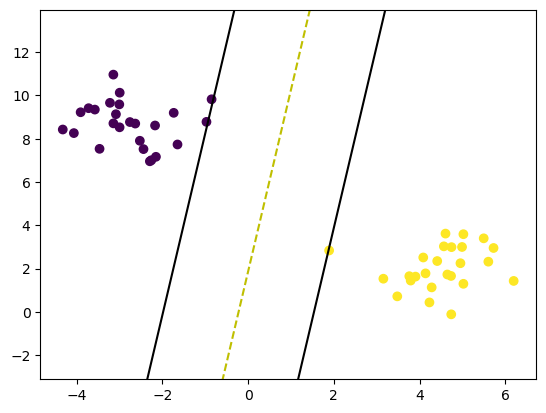

In [24]:
class SVM:
    
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000) -> None:
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        y_ = np.where(y <= 0, -1, 1)
        
        self.w = np.random.uniform(0, 1, n_features)
        self.b = 0
        
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]
                
    
    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)
        
        
X, y = make_blobs(n_samples=50, n_features=2, centers=2, cluster_std=1.05, random_state=42)
y = np.where(y == 0, -1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = SVM()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

print(f"Accuracy = {accuracy(predictions, y_test)}")

def visualize_svm():
    def get_hyperplane_value(x, w, b, offset):
        return (-w[0] * x + b + offset) / w[1]

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.scatter(X[:, 0], X[:, 1], marker="o", c=y)

    x0_1 = np.amin(X[:, 0])
    x0_2 = np.amax(X[:, 0])

    x1_1 = get_hyperplane_value(x0_1, clf.w, clf.b, 0)
    x1_2 = get_hyperplane_value(x0_2, clf.w, clf.b, 0)

    x1_1_m = get_hyperplane_value(x0_1, clf.w, clf.b, -1)
    x1_2_m = get_hyperplane_value(x0_2, clf.w, clf.b, -1)

    x1_1_p = get_hyperplane_value(x0_1, clf.w, clf.b, 1)
    x1_2_p = get_hyperplane_value(x0_2, clf.w, clf.b, 1)

    ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--")
    ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k")
    ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k")

    x1_min = np.amin(X[:, 1])
    x1_max = np.amax(X[:, 1])
    ax.set_ylim([x1_min - 3, x1_max + 3])

    plt.show()

visualize_svm()

### K-Means

(500, 2)
4


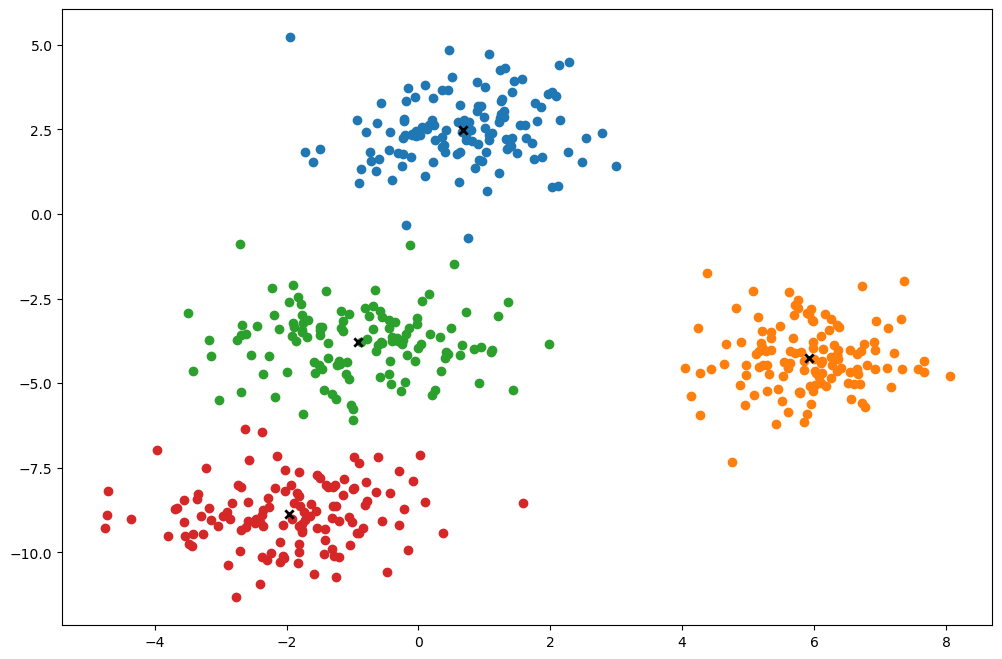

In [35]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1-x2)**2))

class KMeans:

    def __init__(self, K=5, max_iters=100, plot_steps=False):
        self.K = K
        self.max_iters = max_iters
        self.plot_steps = plot_steps

        # list of sample indices for each cluster
        self.clusters = [list() for _ in range(self.K)]

        # the centers (mean vector) for each cluster
        self.centroids = list()


    def predict(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape

        # initialize
        random_sample_idxs = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = [self.X[idx] for idx in random_sample_idxs]

        # optimize clusters
        for _ in range(self.max_iters):
            # assign samples to closest centroids (create clusters)
            self.clusters = self._create_clusters(self.centroids)

            if self.plot_steps:
                self.plot()

            # calculate new centroids from the clusters
            centroids_old = self.centroids
            self.centroids = self._get_centroids(self.clusters)

            if self._is_converged(centroids_old, self.centroids):
                break

            if self.plot_steps:
                self.plot()

        # classify samples as the index of their clusters
        return self._get_cluster_labels(self.clusters)


    def _get_cluster_labels(self, clusters):
        # each sample will get the label of the cluster it was assigned to
        labels = np.empty(self.n_samples)
        for cluster_idx, cluster in enumerate(clusters):
            for sample_idx in cluster:
                labels[sample_idx] = cluster_idx

        return labels


    def _create_clusters(self, centroids):
        # assign the samples to the closest centroids
        clusters = [list() for _ in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters

    def _closest_centroid(self, sample, centroids):
        # distance of the current sample to each centroid
        distances = [euclidean_distance(sample, point) for point in centroids]
        closest_idx = np.argmin(distances)
        return closest_idx


    def _get_centroids(self, clusters):
        # assign mean value of clusters to centroids
        centroids = np.zeros((self.K, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids

    def _is_converged(self, centroids_old, centroids):
        # distances between old and new centroids, for all centroids
        distances = [euclidean_distance(centroids_old[i], centroids[i]) for i in range(self.K)]
        return sum(distances) == 0

    def plot(self):
        fig, ax = plt.subplots(figsize=(12, 8))

        for i, index in enumerate(self.clusters):
            point = self.X[index].T
            ax.scatter(*point)

        for point in self.centroids:
            ax.scatter(*point, marker="x", color="black", linewidth=2)

        plt.show()


X, y = make_blobs(
    centers=4, n_samples=500, n_features=2, shuffle=True, random_state=40
)
print(X.shape)

clusters = len(np.unique(y))
print(clusters)

k = KMeans(K=clusters, max_iters=149, plot_steps=False)
y_pred = k.predict(X)

k.plot()